<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/Nov25_NTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio
!pip install earthengine-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 69.9 MB/s eta 0:00:00


In [ ]:
import ee
ee.Authenticate()  # This will prompt you to authenticate your account
ee.Initialize(project='ee-parkjennyjiyeon')


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [ ]:
dataset = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")
nighttime_lights = dataset.filterDate('2023-01-01', '2023-12-31').median()


In [ ]:
nighttime_lights = nighttime_lights.toFloat()

# Define an area of interest (GeoJSON or bounding box)
aoi = ee.Geometry.Rectangle([124.5, 33.0, 130.0, 39.5]) #Seoul

# Export the nighttime lights to Google Drive
task = ee.batch.Export.image.toDrive(
    image=nighttime_lights,
    description='Nighttime_Lights_korea',
    scale=500,  # Resolution in meters
    region=aoi.getInfo()['coordinates'],
    fileFormat='GeoTIFF'
)
task.start()


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1226, 'height': 1455, 'count': 2, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.004491576420597608, 0.0, 124.49751522612449,
       0.0, -0.004491576420597608, 39.53485565410014)}


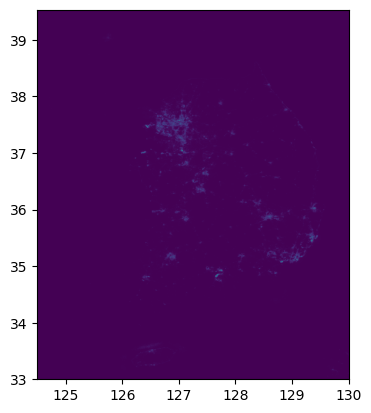

<Axes: >

In [3]:
import rasterio
from rasterio.plot import show

# Load the NTL GeoTIFF file
ntl_path = '/content/drive/MyDrive/Nighttime_Lights_korea.tif'  # Replace with your file path
ntl_data = rasterio.open(ntl_path)

# Display raster metadata
print(ntl_data.meta)

# Plot the raster
show(ntl_data)


  BASE_DATE SIDO_CD     SIDO_NM  \
0  20230701      11  ¼­¿ïÆ¯º°½Ã   
1  20230701      21  ºÎ»ê±¤¿ª½Ã   
2  20230701      22  ´ë±¸±¤¿ª½Ã   
3  20230701      23  ÀÎÃµ±¤¿ª½Ã   
4  20230701      24  ±¤ÁÖ±¤¿ª½Ã   

                                            geometry  
0  POLYGON ((201748.532 566815.017, 201953.244 56...  
1  MULTIPOLYGON (((378441.217 256011.416, 378440....  
2  POLYGON ((330688.544 415299.942, 330688.134 41...  
3  MULTIPOLYGON (((91935.674 481967.049, 91936.11...  
4  POLYGON ((178186.33 295822.605, 178255.423 295...  


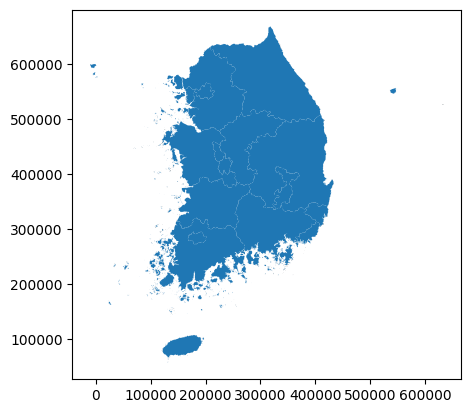

In [4]:
import rasterio
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt

municipalities = gpd.read_file("/content/drive/MyDrive/BND_SIDO_PG/BND_SIDO_PG.shp")
print(municipalities.head())
municipalities.plot()

ntl_raster = rasterio.open("/content/drive/MyDrive/Nighttime_Lights_korea.tif")


In [ ]:
# Check CRS
print("Raster CRS:", ntl_raster.crs)
print("Shapefile CRS:", municipalities.crs)
if municipalities.crs != ntl_raster.crs:
    municipalities = municipalities.to_crs(ntl_raster.crs)


Raster CRS: EPSG:4326
Shapefile CRS: PROJCS["Korea_2000_Korea_Central_Belt_2010",GEOGCS["GCS_Korea_2000",DATUM["Korean_Geodetic_Datum_2002",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6737"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_easting",200000],PARAMETER["false_northing",600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


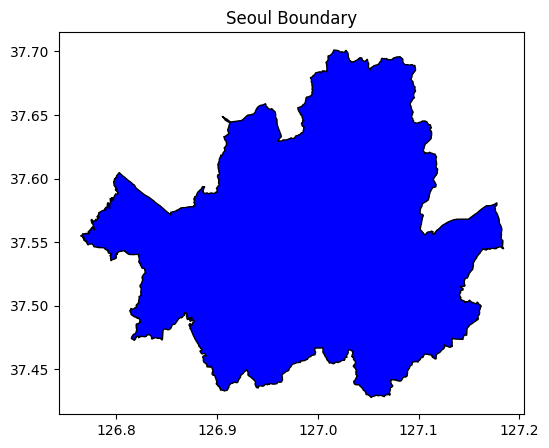

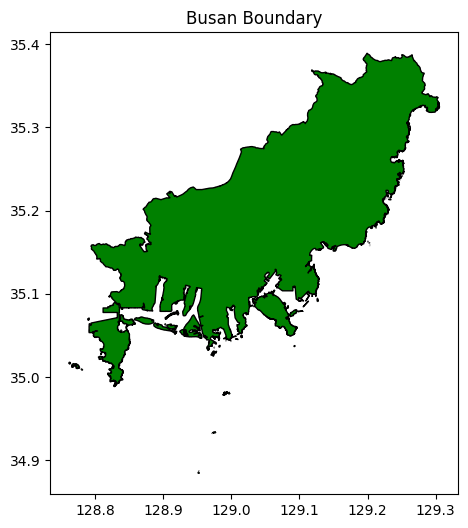

In [ ]:
municipalities['SIDO_CD'] = municipalities['SIDO_CD'].astype(int) # Change to int

seoul = municipalities[municipalities['SIDO_CD'] == 11]
busan = municipalities[municipalities['SIDO_CD'] == 21]

seoul.plot(color="blue", edgecolor="black", figsize=(6, 6))
plt.title("Seoul Boundary")
plt.show()

busan.plot(color="green", edgecolor="black", figsize=(6, 6))
plt.title("Busan Boundary")
plt.show()


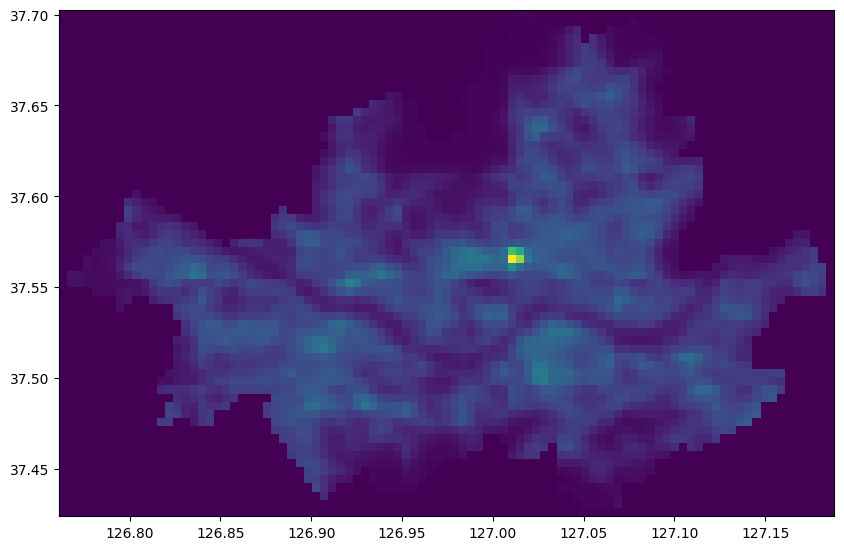

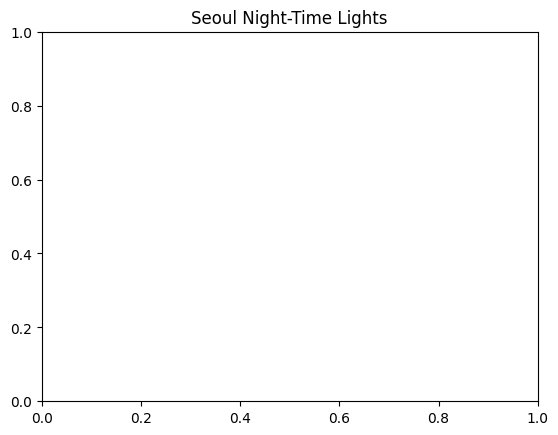

In [ ]:
# Convert Seoul geometry to GeoJSON
seoul_geom = [seoul.geometry.iloc[0].__geo_interface__]  # GeoJSON format

# Mask the raster
seoul_ntl, seoul_transform = mask(ntl_raster, seoul_geom, crop=True)

# Update metadata for the cropped raster
seoul_meta = ntl_raster.meta.copy()
seoul_meta.update({
    "driver": "GTiff",
    "height": seoul_ntl.shape[1],
    "width": seoul_ntl.shape[2],
    "transform": seoul_transform
})

# Save the cropped raster
with rasterio.open("seoul_ntl.tif", "w", **seoul_meta) as dest:
    dest.write(seoul_ntl)

plt.figure(figsize=(10, 8))
# Select the first band (index 0) for display
show(seoul_ntl[0], transform=seoul_transform, cmap="viridis")
plt.title("Seoul Night-Time Lights")
plt.show()



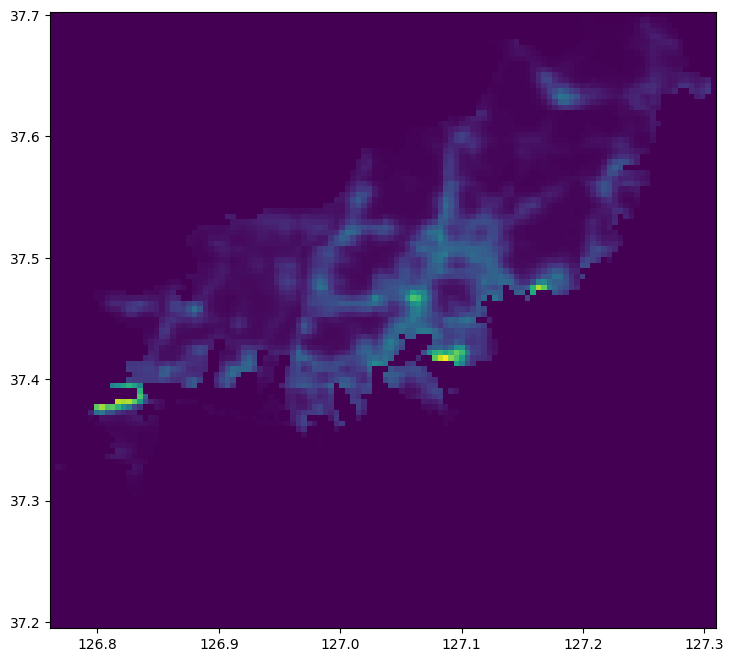

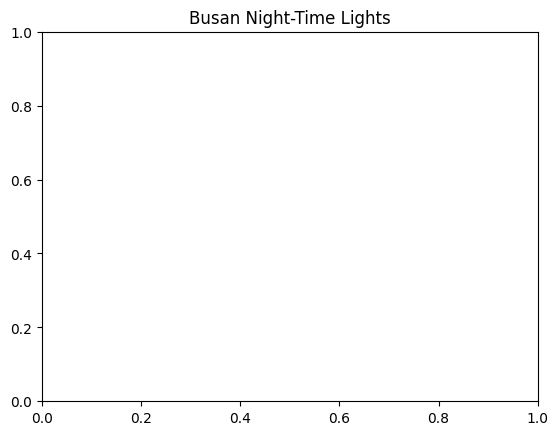

In [ ]:
# Convert Busan geometry to GeoJSON
busan_geom = [busan.geometry.iloc[0].__geo_interface__]  # GeoJSON format

# Mask the raster
busan_ntl, busan_transform = mask(ntl_raster, busan_geom, crop=True)

# Update metadata for the cropped raster
busan_meta = ntl_raster.meta.copy()
busan_meta.update({
    "driver": "GTiff",
    "height": busan_ntl.shape[1],
    "width": busan_ntl.shape[2],
    "transform": busan_transform
})

# Save the cropped raster
with rasterio.open("seoul_ntl.tif", "w", **busan_meta) as dest:
    dest.write(busan_ntl)

plt.figure(figsize=(10, 8))
# Select the first band (index 0) for display
show(busan_ntl[0], transform=seoul_transform, cmap="viridis")
plt.title("Busan Night-Time Lights")
plt.show()




In [ ]:
import numpy as np

# Calculate mean NTL value for Seoul
seoul_mean_ntl = np.mean(seoul_ntl[0][seoul_ntl[0] > 0])  # Exclude zeros (background)
print("Mean NTL for Seoul:", seoul_mean_ntl)

# Calculate mean NTL value for Busan
busan_mean_ntl = np.mean(busan_ntl[0][busan_ntl[0] > 0])  # Exclude zeros (background)
print("Mean NTL for Busan:", busan_mean_ntl)


Mean NTL for Seoul: 48.61497
Mean NTL for Busan: 24.48205


In [ ]:
import numpy as np

# Save Seoul NTL data as a NumPy array
np.save("seoul_ntl.npy", seoul_ntl[0])  # Save the first band
print("Seoul NTL saved as seoul_ntl.npy")
# Save Busan NTL data as a NumPy array
np.save("busan_ntl.npy", busan_ntl[0])  # Save the first band
print("Busan NTL saved as busan_ntl.npy")


Seoul NTL saved as seoul_ntl.npy
Busan NTL saved as busan_ntl.npy


In [ ]:
# Export Seoul NTL as GeoTIFF
with rasterio.open("seoul_ntl_export.tif", "w", **seoul_meta) as dest:
    dest.write(seoul_ntl)
print("Seoul NTL exported as seoul_ntl_export.tif")

# Export Busan NTL as GeoTIFF
with rasterio.open("busan_ntl_export.tif", "w", **busan_meta) as dest:
    dest.write(busan_ntl)
print("Busan NTL exported as busan_ntl_export.tif")


Seoul NTL exported as seoul_ntl_export.tif
Busan NTL exported as busan_ntl_export.tif


In [ ]:
# Normalize Seoul and Busan data to [0, 1] range
seoul_ntl_norm = (seoul_ntl[0] - seoul_ntl[0].min()) / (seoul_ntl[0].max() - seoul_ntl[0].min())
busan_ntl_norm = (busan_ntl[0] - busan_ntl[0].min()) / (busan_ntl[0].max() - busan_ntl[0].min())

# Save normalized arrays
np.save("seoul_ntl_normalized.npy", seoul_ntl_norm)
np.save("busan_ntl_normalized.npy", busan_ntl_norm)

print("Normalized data saved as seoul_ntl_normalized.npy and busan_ntl_normalized.npy")


Normalized data saved as seoul_ntl_normalized.npy and busan_ntl_normalized.npy


In [ ]:
import tensorflow as tf

# Convert Seoul data to TFRecord
def serialize_example(array, label):
    feature = {
        'ntl_data': tf.train.Feature(float_list=tf.train.FloatList(value=array.flatten())),
        'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.encode()]))
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Save Seoul as TFRecord
with tf.io.TFRecordWriter("seoul_ntl.tfrecord") as writer:
    example = serialize_example(seoul_ntl_norm, "Seoul")
    writer.write(example)

# Save Busan as TFRecord
with tf.io.TFRecordWriter("busan_ntl.tfrecord") as writer:
    example = serialize_example(busan_ntl_norm, "Busan")
    writer.write(example)

print("Data exported as TFRecords")


Data exported as TFRecords


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.2 MB/s eta 0:00:00
Cloning into 'the_project'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 253 (delta 94), reused 45 (delta 45), pack-reused 109 (from 1)
Receiving objects: 100% (253/253), 9.62 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Seoul Buildings:
    A0                            A1                   A2          A3  \
0  223  1998202070161786836800000000  2611012000100160026  2611012000   
1  484  1978201965801784846100000000  2611012200100090004  2611012200   
2  225  1992202154291786601000000000  2611012000100330016  2611012000   
3  226  1995202155981786394200000000  2611012000100360003  2611012000   
4  227  0000202088011786989100000000  2611012000100020661  2611012000   

                          A4     A5 A6    A7     A8        A9  ...     A15  \
0  ºÎ»ê±¤¿ª½Ã Áß±¸ º¸¼öµ¿1°¡  16-26  1

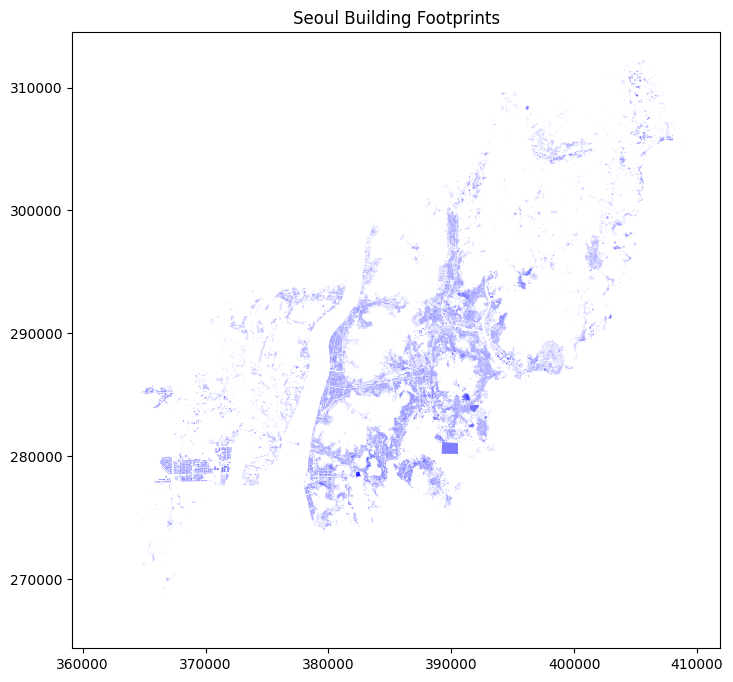

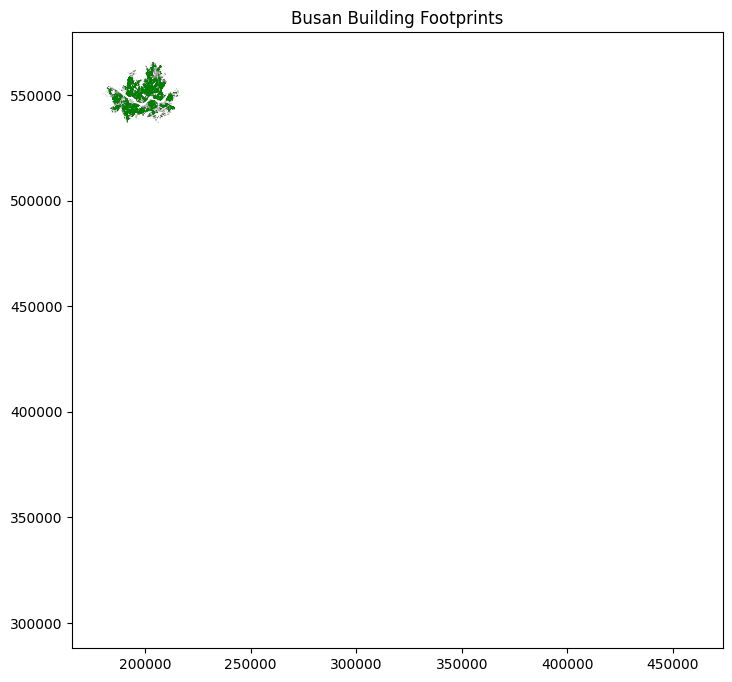

In [1]:
##BUILDING FOOTPRINT SHAPE
!pip install geopandas rasterio shapely matplotlib rasterio

from matplotlib import pyplot as plt
import geopandas as gpd
import rasterio
!git clone https://github.com/podobongbong/the_project.git

# Load the building footprint shapefile
seoul_buildings = gpd.read_file("/content/drive/MyDrive/seoul_2023/AL_D010_11_20231104.shp")
busan_buildings = gpd.read_file("/content/drive/MyDrive/busan_2023/AL_D010_26_20231104.shp")

# Inspect the data
print("Seoul Buildings:")
print(seoul_buildings.head())
print("\nBusan Buildings:")
print(busan_buildings.head())

# Visualize the building footprints
seoul_buildings.plot(figsize=(10, 8), color="blue", alpha=0.5)
plt.title("Seoul Building Footprints")
plt.show()

busan_buildings.plot(figsize=(10, 8), color="green", alpha=0.5)
plt.title("Busan Building Footprints")
plt.show()


In [ ]:
from matplotlib import pyplot as plt

# Load the NTL raster for Seoul and Busan
seoul_ntl = rasterio.open("/content/the_project/data/gis/seoul_ntl.tif")
busan_ntl = rasterio.open("/content/the_project/data/gis/busan_ntl.tif")

# Check CRS of building footprints and raster
print("Seoul Buildings CRS:", seoul_buildings.crs)
print("Seoul NTL CRS:", seoul_ntl.crs)
print("Busan Buildings CRS:", busan_buildings.crs)
print("Busan NTL CRS:", busan_ntl.crs)

# Reproject building footprints if necessary
if seoul_buildings.crs != seoul_ntl.crs:
    seoul_buildings = seoul_buildings.to_crs(seoul_ntl.crs)

if busan_buildings.crs != busan_ntl.crs:
    busan_buildings = busan_buildings.to_crs(busan_ntl.crs)


  BASE_DATE SIDO_CD     SIDO_NM  \
0  20230701      11  ¼­¿ïÆ¯º°½Ã   
1  20230701      21  ºÎ»ê±¤¿ª½Ã   
2  20230701      22  ´ë±¸±¤¿ª½Ã   
3  20230701      23  ÀÎÃµ±¤¿ª½Ã   
4  20230701      24  ±¤ÁÖ±¤¿ª½Ã   

                                            geometry  
0  POLYGON ((201748.532 566815.017, 201953.244 56...  
1  MULTIPOLYGON (((378441.217 256011.416, 378440....  
2  POLYGON ((330688.544 415299.942, 330688.134 41...  
3  MULTIPOLYGON (((91935.674 481967.049, 91936.11...  
4  POLYGON ((178186.33 295822.605, 178255.423 295...  


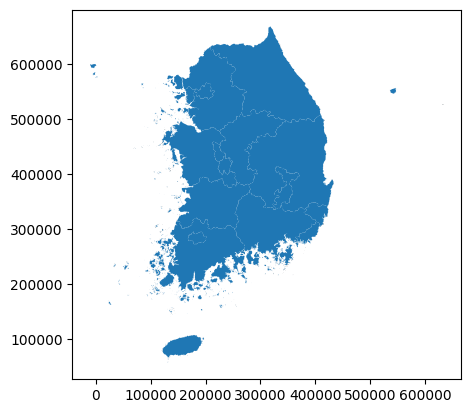

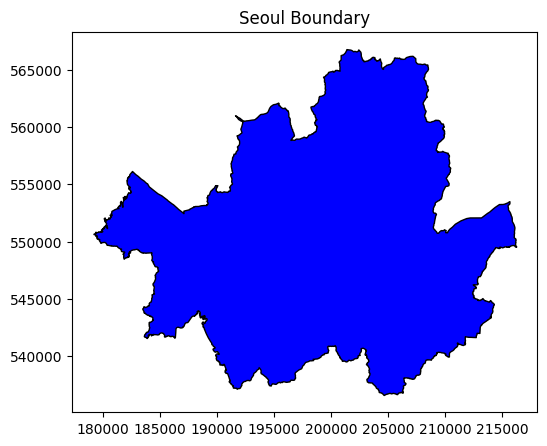

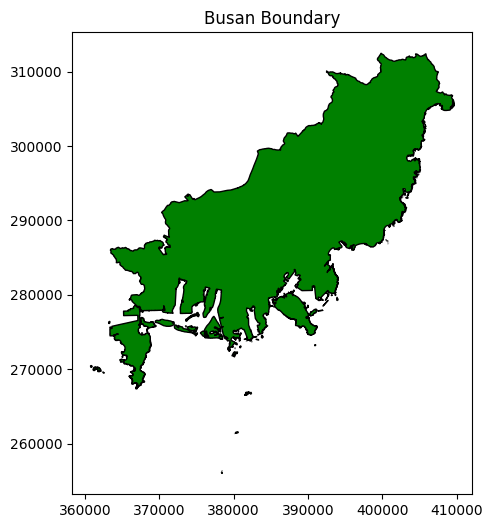

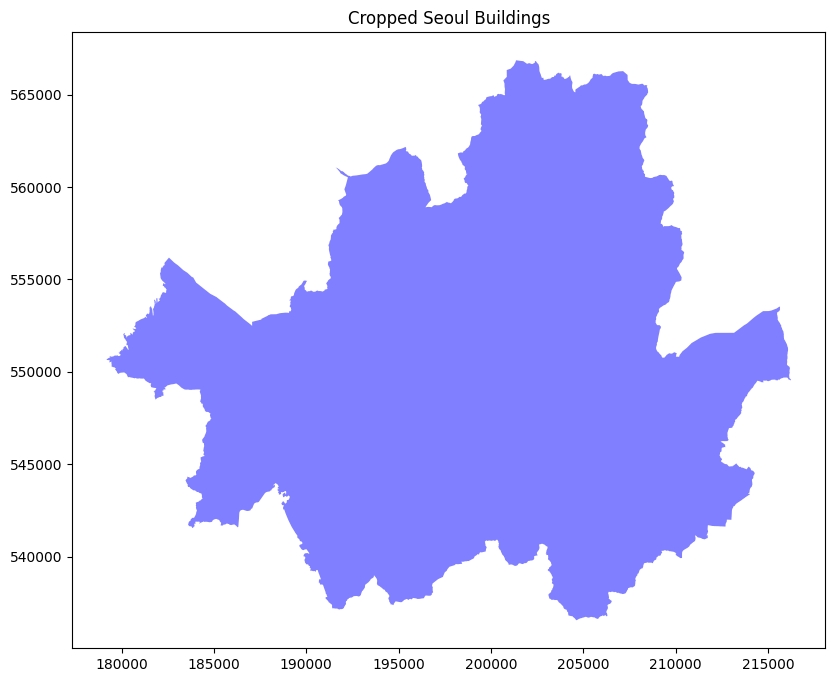

<ipython-input-9-3e6893c189fa>:35: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  busan_cropped.plot(figsize=(10, 8), color="green", alpha=0.5)


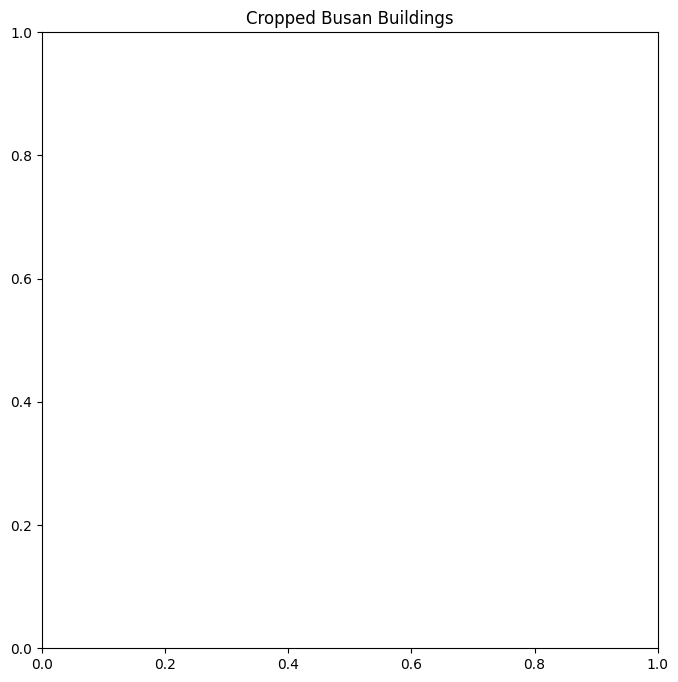

In [9]:
municipalities = gpd.read_file("/content/drive/MyDrive/BND_SIDO_PG/BND_SIDO_PG.shp")
print(municipalities.head())
municipalities.plot()

municipalities['SIDO_CD'] = municipalities['SIDO_CD'].astype(int) # Change to int

seoul = municipalities[municipalities['SIDO_CD'] == 11]
busan = municipalities[municipalities['SIDO_CD'] == 21]

seoul.plot(color="blue", edgecolor="black", figsize=(6, 6))
plt.title("Seoul Boundary")
plt.show()

busan.plot(color="green", edgecolor="black", figsize=(6, 6))
plt.title("Busan Boundary")
plt.show()

# Ensure CRS alignment
if seoul_buildings.crs != seoul.crs:
    seoul_buildings = seoul.to_crs(seoul.crs)
if busan_buildings.crs != busan.crs:
    busan_buildings = busan_buildings.to_crs(busan.crs)

# Crop Seoul buildings
seoul_cropped = gpd.overlay(seoul_buildings, seoul, how='intersection')

# Crop Busan buildings
busan_cropped = gpd.overlay(busan_buildings, busan, how='intersection')

# Visualize cropped results
seoul_cropped.plot(figsize=(10, 8), color="blue", alpha=0.5)
plt.title("Cropped Seoul Buildings")
plt.show()

busan_cropped.plot(figsize=(10, 8), color="green", alpha=0.5)
plt.title("Cropped Busan Buildings")
plt.show()



Seoul Buildings CRS: EPSG:5186
Seoul NTL CRS: EPSG:4326
Busan Buildings CRS: EPSG:5186
Busan NTL CRS: EPSG:4326


In [4]:
from rasterio.features import rasterize
import numpy as np

def rasterize_shapefile(shapefile, raster_template):
    """
    Rasterizes a shapefile to match the dimensions and transform of a given raster.
    """
    # Open the raster template to extract dimensions and transform
    transform = raster_template.transform
    width = raster_template.width
    height = raster_template.height

    # Rasterize
    rasterized = rasterize(
        [(geom, 1) for geom in shapefile.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Fill value for areas with no buildings
        dtype=np.uint8  # Keep memory usage low
    )

    return rasterized

In [5]:
seoul_building_raster = rasterize_shapefile(seoul_buildings, seoul_ntl)

# Save the rasterized building footprint
with rasterio.open(
    "seoul_buildings_raster.tif",
    "w",
    driver="GTiff",
    height=seoul_building_raster.shape[0],
    width=seoul_building_raster.shape[1],
    count=1,
    dtype="uint8",
    crs=seoul_ntl.crs,
    transform=seoul_ntl.transform
) as dest:
    dest.write(seoul_building_raster, indexes=1)


busan_building_raster = rasterize_shapefile(busan_buildings, busan_ntl)

# Save the rasterized building footprint
with rasterio.open(
    "busan_buildings_raster.tif",
    "w",
    driver="GTiff",
    height=busan_building_raster.shape[0],
    width=busan_building_raster.shape[1],
    count=1,
    dtype="uint8",
    crs=busan_ntl.crs,
    transform=busan_ntl.transform
) as dest:
    dest.write(busan_building_raster, indexes=1)


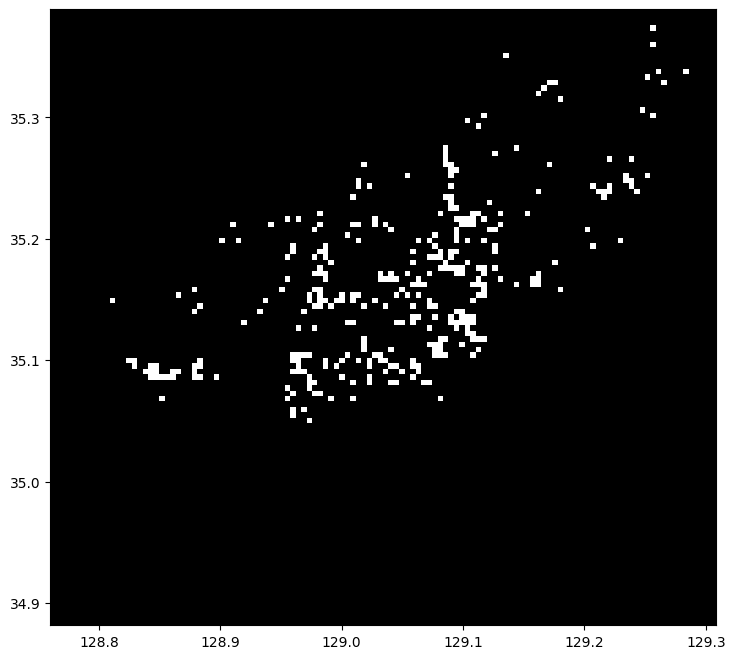

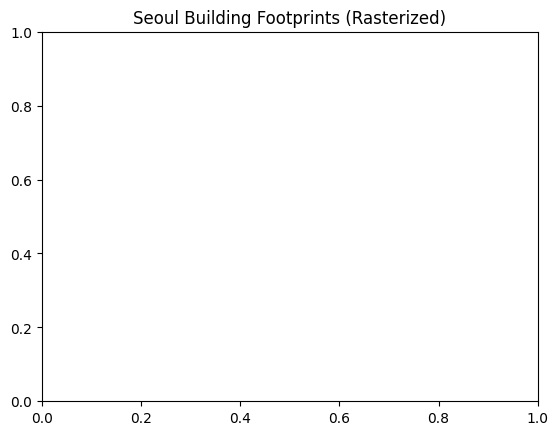

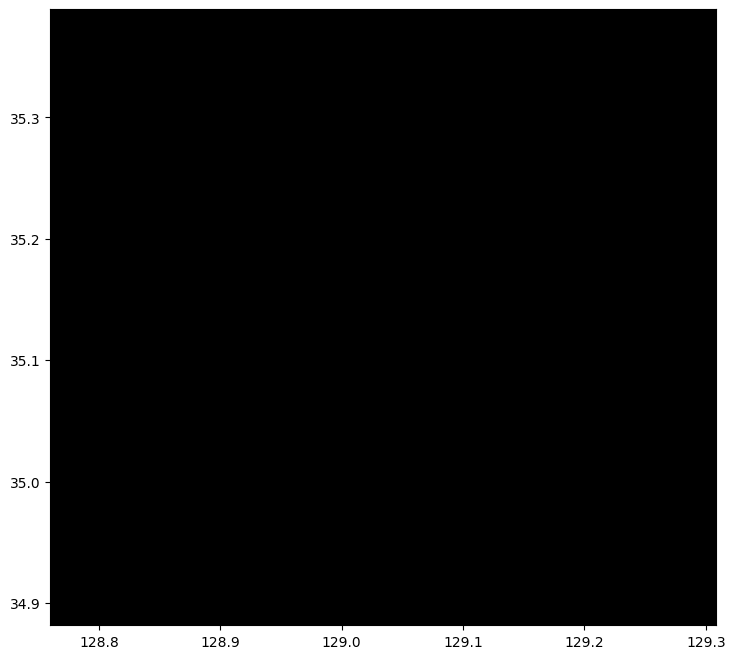

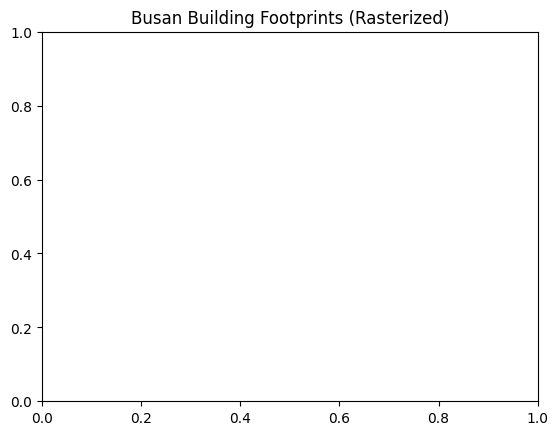

In [7]:
from rasterio.plot import show

plt.figure(figsize=(10, 8))
show(seoul_building_raster, transform=seoul_ntl.transform, cmap="gray")
plt.title("Seoul Building Footprints (Rasterized)")
plt.show()

plt.figure(figsize=(10, 8))
show(busan_building_raster, transform=busan_ntl.transform, cmap="gray")
plt.title("Busan Building Footprints (Rasterized)")
plt.show()


In [ ]:
seoul_combined = seoul_ntl.read(1) * seoul_building_raster
busan_combined = busan_ntl.read(1) * busan_building_raster

# Save combined outputs
np.save("seoul_ntl_building.npy", seoul_combined)
np.save("busan_ntl_building.npy", busan_combined)
